# Make subnetworks

In [1]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
# from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import networkx as nx

from scipy.io import mmread
from scipy.sparse import csr_matrix

/home/apc5un/.conda/envs/celloracle_env18/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

which: no R in (/apps/software/standard/core/jupyterlab/4.4.6-py3.12/sbin:/apps/software/standard/core/jupyterlab/4.4.6-py3.12/bin:/home/apc5un/bedtools2/bin:/opt/conda/bin:/opt/mam/9.1.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/current/bin:/opt/rci/bin:/share/resources/HPCtools:/opt/mam/current/bin:/opt/apptainer/current/bin)


'0.20.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

#### Load links and remove Mef2c connections from KO

In [4]:
thresh_num = 12000

links_atr = co.load_hdf5(file_path="./data/atrial-vent-040125/atriallinks_alpha1000.celloracle.links")
links_vent = co.load_hdf5(file_path="./data/atrial-vent-040125/ventlinks_alpha1000.celloracle.links")

links_atr.filter_links(p=.001, weight="coef_abs", threshold_number=thresh_num)
links_vent.filter_links(p=.001, weight="coef_abs", threshold_number=thresh_num)

In [5]:
links_atr.filtered_links['AtrialCMs'].to_csv(f"./data/atrial-vent-040125/atrial_{thresh_num}.csv", index=False)
links_vent.filtered_links['VentCMs'].to_csv(f"./data/atrial-vent-040125/vent_{thresh_num}.csv", index=False)

In [19]:
x = links_atr.filtered_links['AtrialCMs']
x[x.target == 'TNNT2']
# x = links_vent.filtered_links['VentCMs']
# x[x.source == 'RREB1']

,source,target,coef_mean,coef_abs,p,-logp
58267,MAZ,TNNT2,0.112840,0.112840,3.867355e-16,15.412586
58265,HEY1,TNNT2,0.071725,0.071725,8.027858e-11,10.095400
58260,SMC3,TNNT2,0.070531,0.070531,1.904324e-17,16.720259
58276,MEF2A,TNNT2,0.066431,0.066431,9.325763e-18,17.030316
58269,STAT3,TNNT2,0.058634,0.058634,1.595637e-13,12.797066
58261,EGR1,TNNT2,0.052534,0.052534,3.807029e-09,8.419414
58255,GTF2I,TNNT2,0.044872,0.044872,5.543660e-13,12.256203
58277,MEF2C,TNNT2,0.041520,0.041520,1.354214e-10,9.868313
58279,HES4,TNNT2,0.035789,0.035789,4.479410e-07,6.348779


# Figure 1U – Atrial and VentricularSubnetworks

Higher quality version of these subnetworks can be made using the `visualize-pyvis.py` script.

This is the `plot_subnetwork()` function. It will return a `networkx` network for visualization.



In [8]:
def plot_subnetwork(network, tf_genes, targets):
    graph_df = {'source': [],
                 'target': [],
                 'weight': [],
                 'edge_cols': []}
    
    for curr_gene in tf_genes:
        curr_gene_df = network[network['source'] == curr_gene]
        gene_df_targs = curr_gene_df[curr_gene_df['target'].isin(targets)]

        for index, row in gene_df_targs.iterrows():
            graph_df['source'].append(row['source'])
            graph_df['target'].append(row['target'])
            graph_df['weight'].append(row['coef_mean'])
            if row['coef_mean'] > 0:
                graph_df['edge_cols'].append('green')
            else:
                graph_df['edge_cols'].append('red')

    graph_df = pd.DataFrame(graph_df)

    G = nx.from_pandas_edgelist(graph_df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    
    from pyvis.network import Network
    net = Network(notebook=True, directed=True)
    # net.force_atlas_2based(gravity=-30, central_gravity=0.005, spring_length=80, spring_strength=0.05, damping=0.8)
    net.force_atlas_2based(gravity=-20)
    net.from_nx(G)

    for edge in net.edges:
        if edge['width'] > 0:
            edge['color'] = 'grey'
            edge['arrowStrikethrough'] = False
        else:
            edge['color'] = 'red'
            edge['arrows'] = {"to": {"enabled": True, "type": "bar", "scaleFactor":.4}}

        edge['value'] = np.abs(edge['width'])

    for node in net.nodes:
        if node['id'] in tf_genes:
            node['shape'] = 'diamond'
            node['color'] = 'grey'
            node['size'] = 30
            node['font'] = {'size': 90, 'color': 'black'}
        else:
            node['color'] = 'grey' # Black is neither
            node['font'] = {'size': 1, 'color': 'black'}
            node['size'] = 2

    G_act = nx.from_pandas_edgelist(graph_df[graph_df.weight > 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    G_inact = nx.from_pandas_edgelist(graph_df[graph_df.weight < 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
            
    return net, G_act, G_inact

### Visualize Ventricular Subnetwork

In [12]:
# Selected genes of interest
genes_for_subnetwork = ['TBX5', 'NR2F2', 'MEF2C', 'NKX2-5', 'MEIS2', 'GATA4', 'HAND1', 'IRX4', 'HEY2', 'PLAGL1', 'NR2F1', 'HES4', 'E2F1', 'HEY1']
genes_for_subnetwork = ['MEF2C', 'MEF2A']

In [13]:
x = links_vent.filtered_links['VentCMs']
c = []
c = [c + list(x[x.source == curr_tf].target.values) for curr_tf in genes_for_subnetwork]
targets = [item for sublist in c for item in sublist]

In [14]:
net, G_act, G_inact = plot_subnetwork(links_vent.filtered_links['VentCMs'], genes_for_subnetwork, targets)
net.show('net.html')

net.html


### Visualize Atrial Subnetwork

In [10]:
x = links_atr.filtered_links['AtrialCMs']
c = []
c = [c + list(x[x.source == curr_tf].target.values) for curr_tf in genes_for_subnetwork]
targets = [item for sublist in c for item in sublist]

In [11]:
net, G_act, G_inact = plot_subnetwork(links_atr.filtered_links['AtrialCMs'], genes_for_subnetwork, targets)
net.show('net.html')

net.html


# Figure 1V – Centrality Bar Charts

In [30]:
links_atr.get_network_score()
links_vent.get_network_score()
centrality_type = 'betweenness_centrality' # 'degree_out'
centrality_type = 'degree_out' # 'degree_out'
atr = links_atr.merged_score[links_atr.merged_score.cluster == 'AtrialCMs'][centrality_type]
vent = links_vent.merged_score[links_vent.merged_score.cluster == 'VentCMs'][centrality_type]

In [31]:
tfs = ['HEY2', 'HAND1', 'E2F1', 'HES4', 'NR2F2', 'HEY1', 'NR2F1', 'PLAGL1', 'TBX5']
tfs = vent.sort_values(ascending=False).index[:30]
filtered = {'Atr': [], 'Vent': []}

for tf in tfs:
    if tf in vent.index:
        filtered['Vent'].append(vent.loc[[tf]].values[0])
    else:
        filtered['Vent'].append(0)
        
    if tf in atr.index:
        filtered['Atr'].append(atr.loc[[tf]].values[0])
    else:
        filtered['Atr'].append(0)
filtered = pd.DataFrame(filtered, index=tfs)

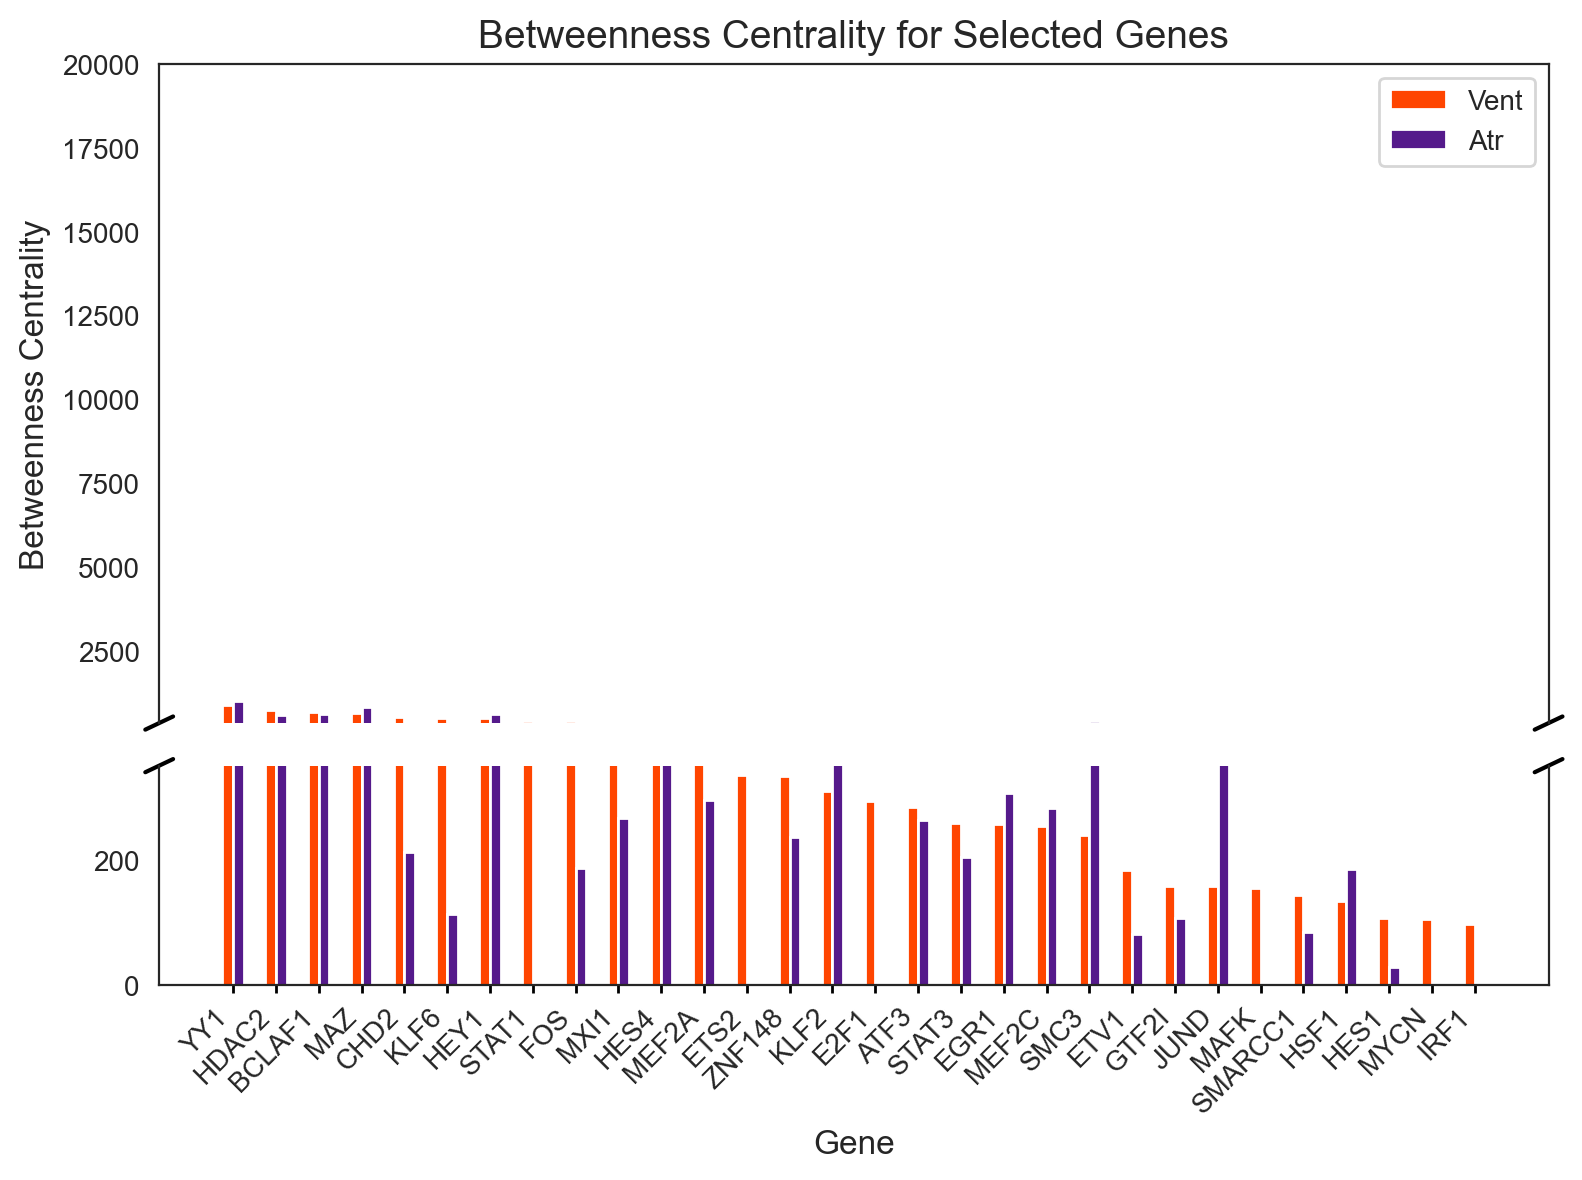

In [32]:
import matplotlib.pyplot as plt

x_positions = range(len(filtered.index))
bar_width = 0.25

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})

# Plot upper part (50–12000)
ax1.bar([x - bar_width/2 for x in x_positions], filtered['Vent'], width=bar_width, label='Vent', color='#FF4500')
ax1.bar([x + bar_width/2 for x in x_positions], filtered['Atr'], width=bar_width, label='Atr', color='#551A8B')
ax1.set_ylim(350, 20000)

# Plot lower part (0–50)
ax2.bar([x - bar_width/2 for x in x_positions], filtered['Vent'], width=bar_width, label='Vent', color='#FF4500')
ax2.bar([x + bar_width/2 for x in x_positions], filtered['Atr'], width=bar_width, label='Atr', color='#551A8B')

ax2.set_ylim(0, 350)

# Hide the spines between ax1 and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # don't put tick labels at the top subplot
ax2.xaxis.tick_bottom()

# Add diagonal lines to show break
d = .01  # proportion of diagonal cut
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d*3, 1 + d*3), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d*3, 1 + d*3), **kwargs)  # bottom-right diagonal

# Labels and formatting
ax2.set_xlabel('Gene', fontsize=12)
ax1.set_ylabel('Betweenness Centrality', fontsize=12)
ax1.set_title('Betweenness Centrality for Selected Genes', fontsize=14)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(filtered.index, rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=10)

plt.tight_layout()
plt.tick_params(axis='x', direction='out', length=3, width=1, color='black', bottom=True, top=False)
# matplotlib.rcParams['pdf.fonttype'] = 42
# plt.savefig(f'./figures/f-atr-vent_split_{centrality_type}.pdf', transparent=True)
# plt.savefig(f'./betweenness-sorted-by-vent.pdf', transparent=True)


plt.show()


In [33]:
atr = links_atr.merged_score[links_atr.merged_score.cluster == 'AtrialCMs'][centrality_type]
vent = links_vent.merged_score[links_vent.merged_score.cluster == 'VentCMs'][centrality_type]

In [34]:
tfs = ['HEY2', 'HAND1', 'E2F1', 'HES4', 'NR2F2', 'HEY1', 'NR2F1', 'PLAGL1', 'TBX5']
tfs = atr.sort_values(ascending=False).index[:30]
filtered = {'Atr': [], 'Vent': []}

for tf in tfs:
    if tf in vent.index:
        filtered['Vent'].append(vent.loc[[tf]].values[0])
    else:
        filtered['Vent'].append(0)
        
    if tf in atr.index:
        filtered['Atr'].append(atr.loc[[tf]].values[0])
    else:
        filtered['Atr'].append(0)
filtered = pd.DataFrame(filtered, index=tfs)

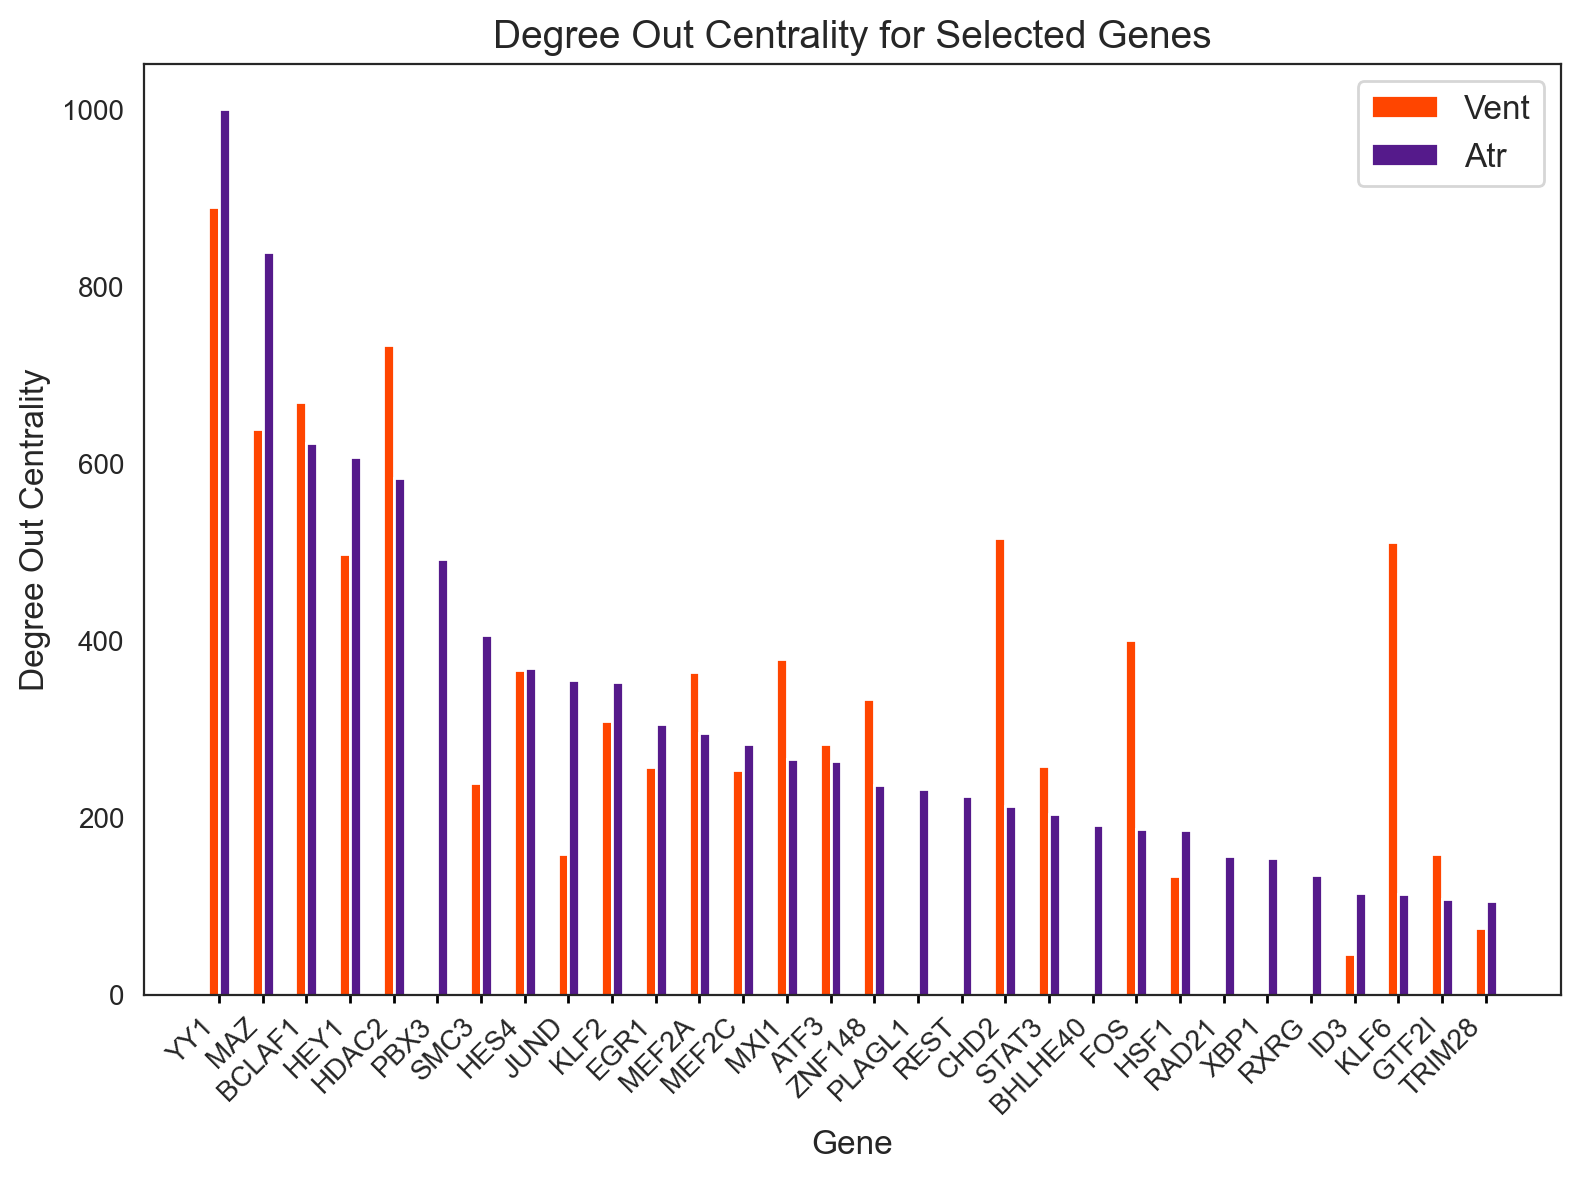

In [35]:
plt.figure(figsize=(8, 6))
x_positions = range(len(filtered.index))
bar_width = 0.25

# Plot each set of bars
plt.bar([x - bar_width/2 for x in x_positions], filtered['Vent'], width=bar_width, label='Vent', color='#FF4500')
plt.bar([x + bar_width/2 for x in x_positions], filtered['Atr'], width=bar_width, label='Atr', color='#551A8B')

# Adding labels and title
plt.xlabel('Gene', fontsize=12)
plt.ylabel('Degree Out Centrality', fontsize=12)
plt.title('Degree Out Centrality for Selected Genes', fontsize=14)
plt.xticks(x_positions, filtered.index, rotation=45, ha='right', fontsize=10)

plt.legend(fontsize=12)
plt.tight_layout()
# plt.ylim(0, 10000)
plt.tick_params(axis='x', direction='out', length=3, width=1, color='black', bottom=True, top=False)

# matplotlib.rcParams['pdf.fonttype'] = 42
# plt.savefig(f'./figures/f-atr-vent_{centrality_type}.pdf', transparent=True)
plt.savefig(f'./degree-sorted-by-vent.pdf', transparent=True)


# Display the plot
plt.show()

# Figure 1W – Wheel Diagrams

In [19]:
def get_gene_targets(tf, links_wt, links_ko):
    wt_targets = links_wt[links_wt.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    ko_targets = links_ko[links_ko.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    
    intersect_targets = [x for x in wt_targets if x in ko_targets]
    
    wt_only_targets = [x for x in wt_targets if x not in ko_targets]

    ko_only_targets = [x for x in ko_targets if x not in wt_targets]
    
    return intersect_targets, wt_only_targets, ko_only_targets

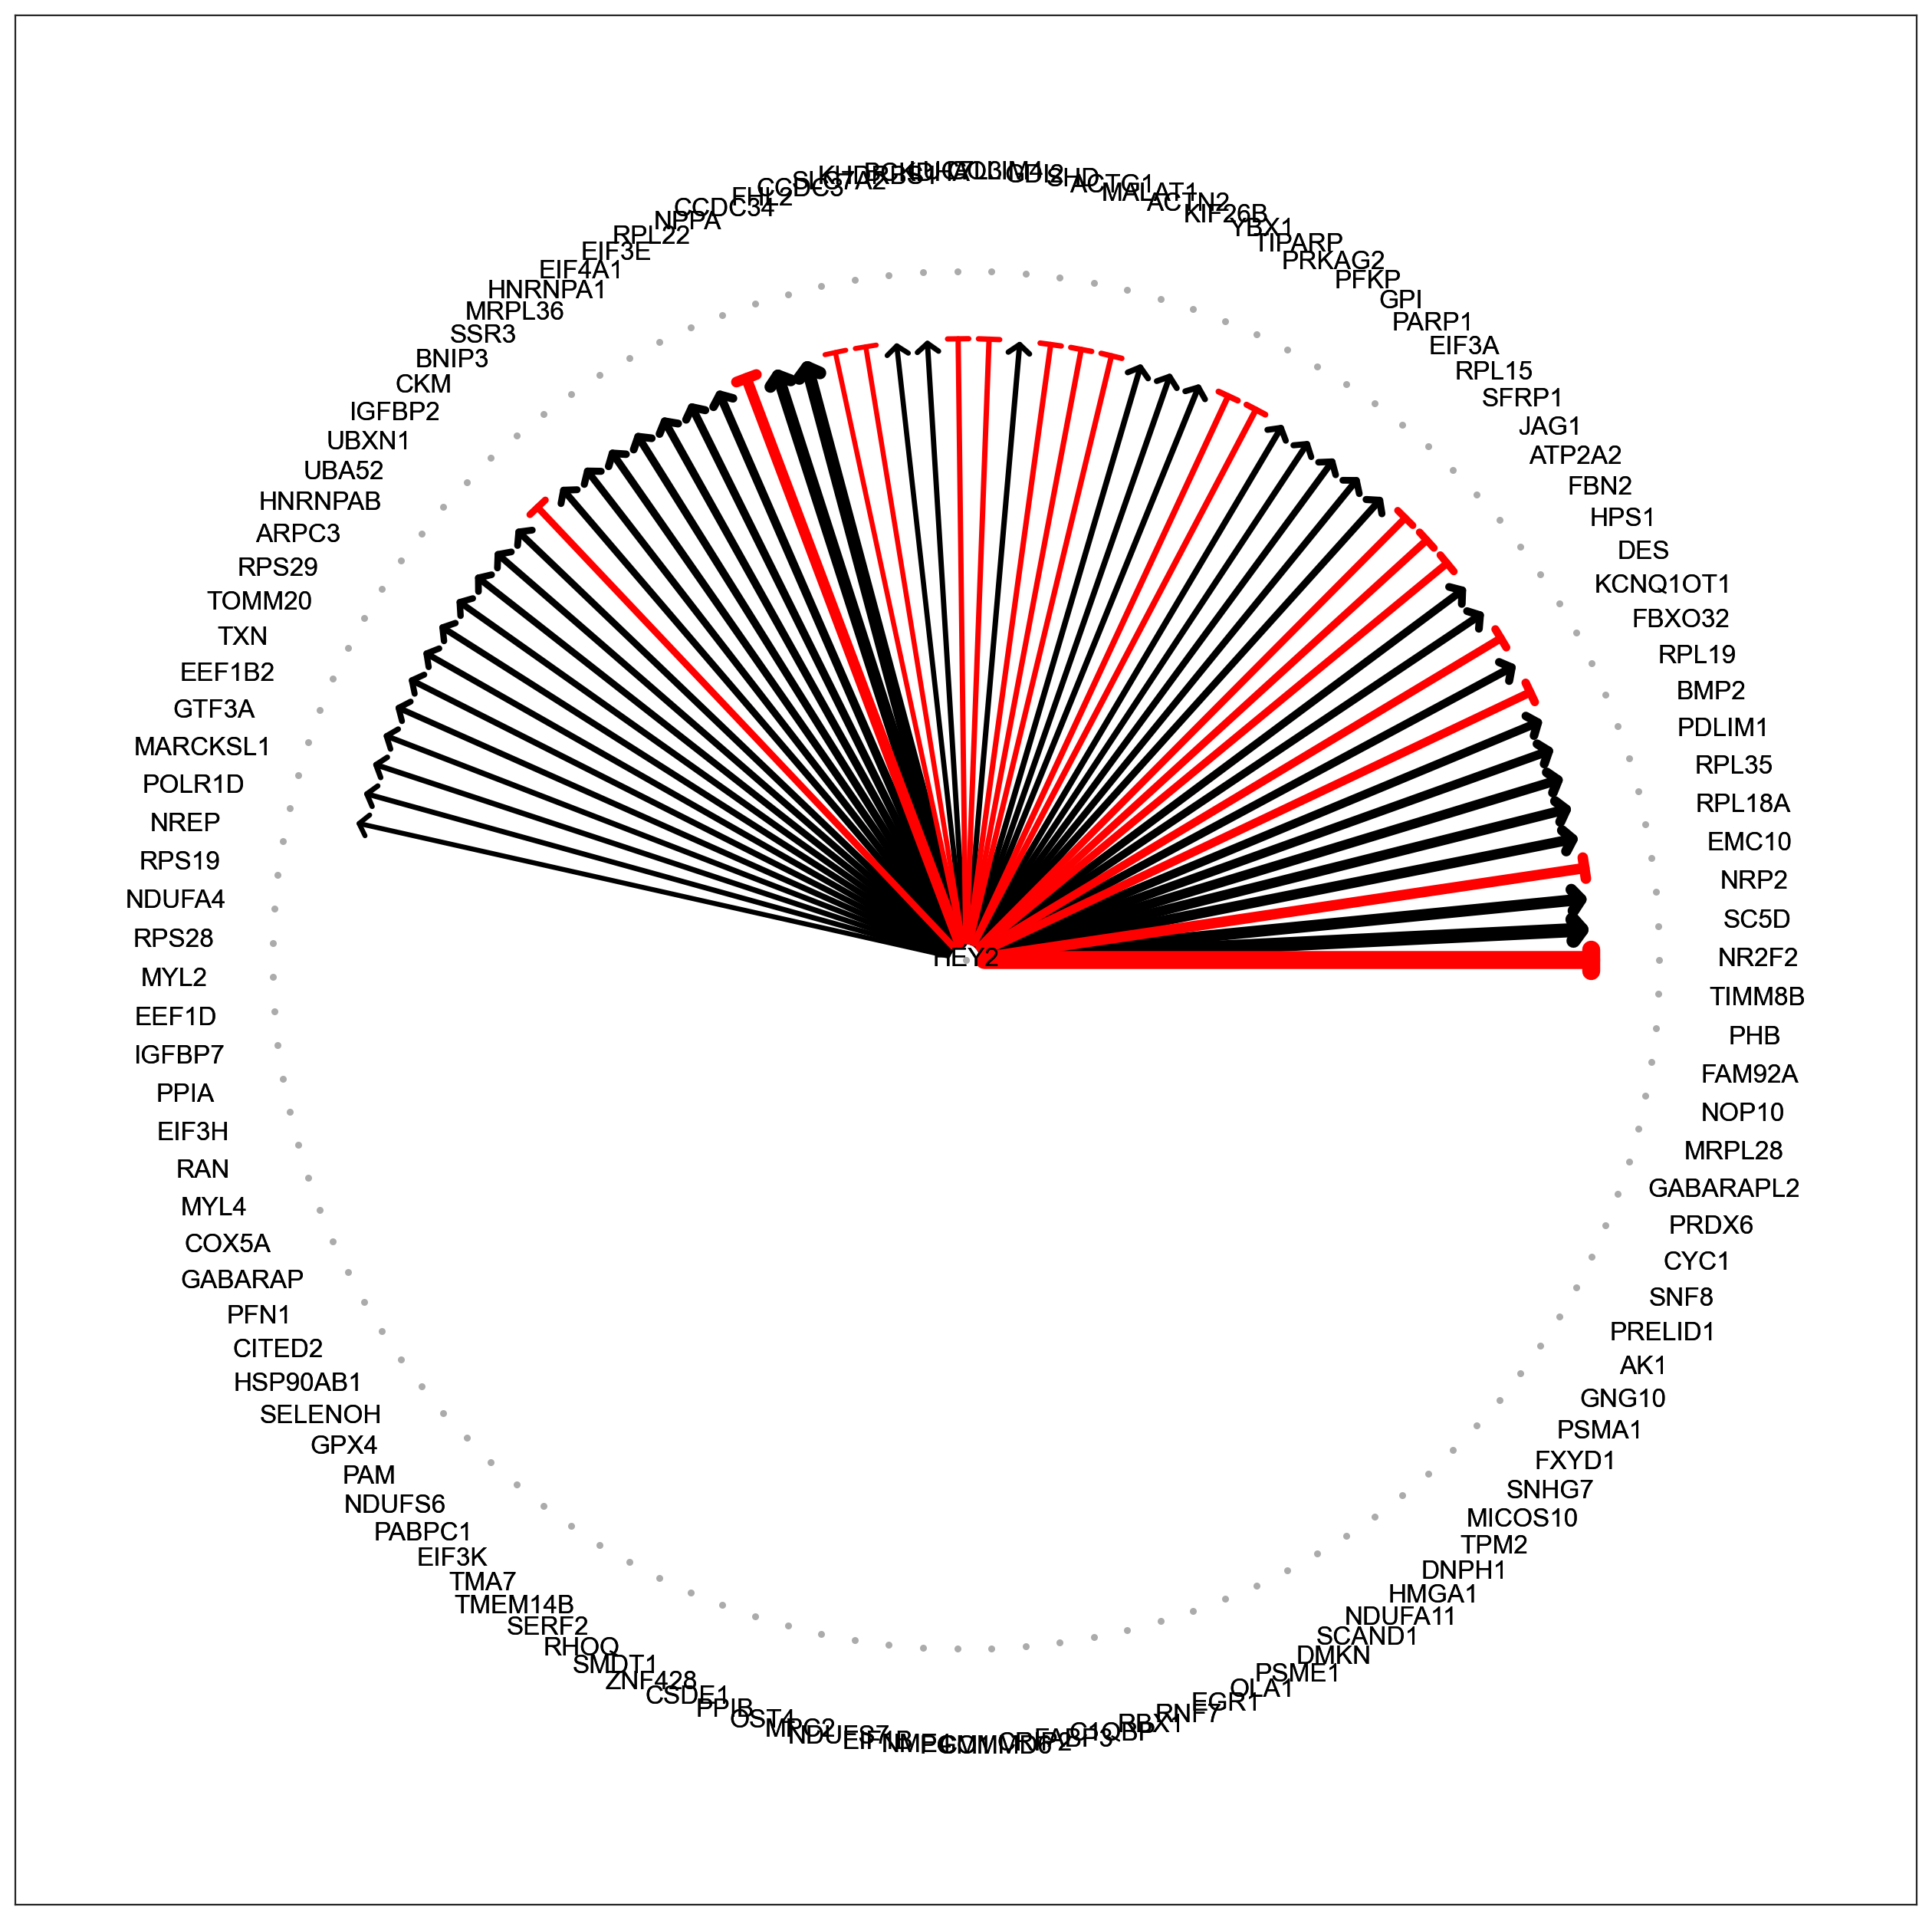

In [52]:
import networkx as nx
import numpy as np
import math
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

links_wt = links_atr.filtered_links['AtrialCMs']
links_ko = links_vent.filtered_links['VentCMs']

wt_or_ko = 'wt'
# wt_or_ko = 'ko'
tf = 'HEY2'

intersect_targets, wt_targets, ko_targets = get_gene_targets(tf, links_wt, links_ko)

matplotlib.rc('font', family='Arial')
fig, ax = plt.subplots(figsize=(16, 16))

all_nodes = wt_targets + intersect_targets +  ko_targets

G_act = nx.DiGraph()
G_act.add_nodes_from(all_nodes)
G_inhib = nx.DiGraph()
G_inhib.add_nodes_from(all_nodes)

pos = nx.circular_layout(G_act.subgraph(all_nodes))

G_act.add_node(tf)
G_inhib.add_node(tf)

if wt_or_ko == 'wt':
    tf_links = links_wt[links_wt.source == tf]
else:
    tf_links = links_ko[links_ko.source == tf]
    
for x in tf_links.target:
    connection = tf_links[tf_links.target == x]
    if connection.coef_mean.values[0] < 0:
        G_inhib.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='red')
    else:
        G_act.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='black')
        

for i, G in enumerate([G_act, G_inhib]):
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*2 for u,v in edges]
    center_node = tf
    pos[center_node] = np.array([0, 0])
    
    pos_higher = nx.rescale_layout_dict(pos, 16)
    nx.draw_networkx_labels(G, pos_higher)
    
    pos_lower = nx.rescale_layout_dict(pos, 13)

    if i == 0:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('->', head_length=0.4, head_width=0.5))
    else:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('|-|', widthA=0, angleA=0, widthB=.5, angleB=0))


pos_mid = nx.rescale_layout_dict(pos, 14)
nx.draw_networkx_nodes(G, pos_mid, node_color="#ababab", node_size=5)

x_values, y_values = zip(*pos_higher.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.1
plt.xlim(float(x_min - x_margin), float(x_max + x_margin))

y_max = max(y_values)
y_min = min(y_values)
y_margin = (y_max - y_min) * 0.1
plt.ylim(float(y_min - y_margin), float(y_max + y_margin))
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
plt.savefig(f"./data/{tf}-{wt_or_ko}.pdf", format='pdf')

## Gene Ontology of direct connections

In [91]:
x = links_atr.filtered_links['AtrialCMs']
z = [print(y) for y in x[x.source == 'HEY1']['target'].values]

NPPA
RPS10
CKM
RPL22
BMP2
TBX2-AS1
MDK
LGALS3
EEF1B2
TRH
RPL31
RPL29
HINT1
NUDT4
COX6B1
RPL12
ATP5MF
RPL35
RPS29
RPL18A
RPL19
MYL4
TNNI3
TPM2
DOK4
PPP1R1A
HADHB
RPL7
ATP1B1
SNHG5
TMSB10
EEF2
RPL18
NOP53
FHL2
UBA52
NDUFB10
EIF3G
RPS21
SEC61G
RPL8
DMKN
EEF1D
RPL15
CCT7
YBX1
HADHA
EEF1A2
SELENOH
C12orf75
RABGAP1L
BRI3
EID1
SNHG6
NR2F2
MLF1
EDF1
LBH
RHOQ
HAND2-AS1
TIMM13
NDUFA4
PPP1R16A
CPE
TPM1
EPB41L4A-AS1
COL1A2
UBXN1
MRPS24
HSPB1
RPS26
TIPARP
TMEM176B
TOMM20
CSDE1
TMOD1
RPLP2
NREP
AP2M1
YBX3
PPDPF
PPP1R14A
IDH2
SMDT1
RPL3
COX7A2
TBCA
GPX3
NME4
HSP90AB1
MYOCD
EIF3K
THYN1
ZFAS1
EIF3E
PHPT1
PARK7
NUCKS1
EIF3H
TNNT2
GNG11
PKIG
SSR2
TBX2
SLIT3
CENPV
SPCS1
ETFA
COX5A
NME2
MRPL21
COL2A1
CAMK2D
ACTC1
ARPC3
CRIP1
CMYA5
MYL9
ELOB
NEXN
TRIM55
SERBP1
PRKAG2
AHCY
HNRNPA1
MGST1
TMEM14B
METTL26
PSMA7
ID4
RAN
TGM2
PHB
MYL6
CPVL
ATP5MC3
ACTN2
CYBA
SNHG32
WDR83OS
TXN
ARPC1A
PABPC1
CLNS1A
PSMB6
GAMT
TFPI2
SNHG8
MTUS1
TMEM14C
OLA1
PRDX6
CADPS2
CCT4
PCBP2
COL23A1
RAC1
ACAA2
PSME1
KCNIP2
CIAO2B
NDUFA3
NDUFA